In [148]:
import os
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import box as Box
from shapely import affinity
from typing import List

import vista
from vista.entities.sensors.camera_utils.ViewSynthesis import DepthModes
from vista.utils import logging, misc
from vista.tasks import MultiAgentBase
from vista.utils import transform

In [186]:
def compute_overlap(poly: Box, polys: List[Box]) -> List[float]:
    """ Compute overlapping area between 1 polygons and N polygons.

    Args:
        poly (shapely.geometry.Box): A polygon.
        poly (List): A list of polygon.

    Returns:
        List[float]: Intersecting area between polygons.

    """
    n_polys = len(polys)
    overlap = np.zeros((n_polys))
    for i in range(n_polys):
        intersection = polys[i].intersection(poly)
        overlap[i] = intersection.area
    return overlap

In [201]:
def my_reward_fn(task, agent_id, **kwargs):
    agent = [_a for _a in task.world.agents if _a.id == agent_id][0]
    other_agents = [_a for _a in task.world.agents if _a.id != agent_id]

    # Lane reward
    q_lat = np.abs(agent.relative_state.x)
    road_width = agent.trace.road_width
    z_lat = road_width / 2
    lane_reward = round(1 - (q_lat/z_lat)**2, 4)

    # collision avoidance reward
    agent2poly = lambda _x: misc.agent2poly(
        _x, ref_dynamics=agent.human_dynamics)
    poly = agent2poly(agent).buffer(5)
    other_polys = list(map(agent2poly, other_agents))
    overlap = compute_overlap(poly, other_polys) / poly.area

    reward = lane_reward - overlap
    return reward, {}

2023-07-30 15:37:05,454::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-07-30 15:37:05,616::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-07-30 15:37:05,788::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-07-30 15:37:05,959::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv


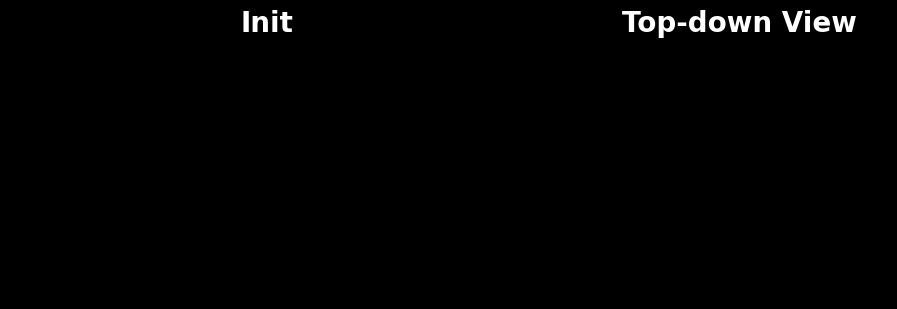

In [202]:
# Initialize the simulator
trace_config = dict(
    road_width=4,
    reset_mode='default',
    master_sensor='camera_front',
)
car_config = dict(
    length=5.,
    width=2.,
    wheel_base=2.78,
    steering_ratio=14.7,
    lookahead_road=True,
)
sensors_config = [
    dict(
        type='camera',
        # camera params
        name='camera_front',
        size=(200, 320),
        # rendering params
        depth_mode=DepthModes.FIXED_PLANE,
        use_lighting=False,
    )
]
task_config = dict(n_agents=2,
                    mesh_dir="../carpack01",
                    init_dist_range=[15., 30.],
                    init_lat_noise_range=[-3., 3.],
                    reward_fn=my_reward_fn)
display_config = dict(road_buffer_size=1000, )

ego_car_config = copy.deepcopy(car_config)
ego_car_config['lookahead_road'] = True
trace_root = "../trace"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]
env = MultiAgentBase(trace_paths=trace_path,
                        trace_config=trace_config,
                        car_configs=[car_config] * task_config['n_agents'],
                        sensors_configs=[sensors_config] + [[]] *
                        (task_config['n_agents'] - 1),
                        task_config=task_config)
display = vista.Display(env.world, display_config=display_config)

In [203]:
def generate_human_actions(world):
    actions = dict()
    for agent in world.agents:
        if agent.id != env.ego_agent.id:
            actions[agent.id] = np.array([0.0,0.0])
        else:
            # Sample a random curvature (between +/- 1/3), keep speed constant
            # curvature = np.random.uniform(-1/5, 1/5)
            if np.random.binomial(1, 0.0):
                curvature = np.random.uniform(-1/5, 1/5)
            else:
                curvature = agent.trace.f_curvature(agent.timestamp)
            actions[agent.id] = np.array([curvature, agent.trace.f_speed(agent.timestamp)])
    return actions

In [204]:
# start env
env.reset();
display.reset()  # reset should be called after env reset
print(f"Ego agent id: {env.ego_agent.id}")

Ego agent id: d9487c


In [205]:
print(env.ego_agent.id)
env.ego_agent.ego_dynamics.steering

d9487c


-0.059353734576192634

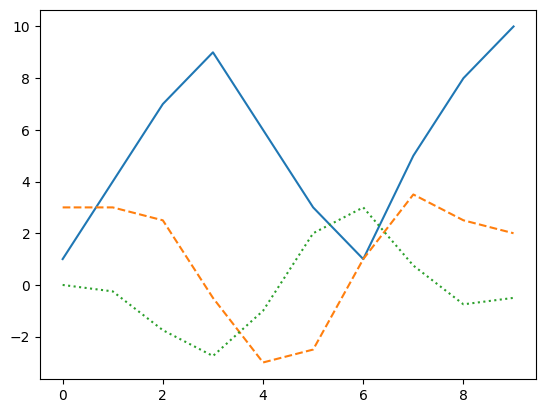

In [206]:
import numpy as np
# Example data
data = [1, 4, 7, 9, 6, 3, 1, 5, 8, 10]
first_derivative = np.gradient(data)
second_derivative = np.gradient(first_derivative)
plt.plot(data,'-')
plt.plot(first_derivative,'--')
plt.plot(second_derivative,':')

In [207]:
def calculate_jitter_reward(steering_history):
    first_derivative = np.gradient(steering_history)
    second_derivative = np.gradient(first_derivative)
    jitter_reward = -np.abs(second_derivative[-1])
    return jitter_reward

In [209]:
steering_history = [0.0]
done = False
while not done:
    # follow nominal trajectories for all agents
    actions = generate_human_actions(env.world)

    # step environment
    observations, rewards, dones, infos = env.step(actions)
    # TODO: see if we can just add the jitter second derivative in addition to the reward returned from env.step()
    steering = env.ego_agent.ego_dynamics.steering
    steering_history.append(steering)
    jitter_reward = calculate_jitter_reward(steering_history)

    # print(f"Steering: {steering}")
    # print(f"Second steering derivative: {jitter_reward}")
    
    # print(f"Reward: {rewards[env.ego_agent.id]}")
    done = dones[env.ego_agent.id]
    reward = 0 if done else rewards[env.ego_agent.id] + jitter_reward
    print(f"reward: {reward}")

    img = display.render()
    cv2.imshow("test", img[:, :, ::-1])
    key = cv2.waitKey(20)
    plt.pause(.05)
    if key == ord('q'):
        break

reward: [1.]
reward: [0.96529043]
reward: [0.99996024]
reward: [0.99997671]
reward: [0.99992947]
reward: [0.9999168]
reward: [0.99992814]
reward: [0.99999364]
reward: [0.99994711]
reward: [0.99996301]
reward: [0.99999519]
reward: [0.99999534]
reward: [0.99990501]
reward: [0.99996039]
reward: [0.99995321]
reward: [0.99999692]
reward: [0.99999857]
reward: [0.99999402]
reward: [0.9999897]
reward: [0.99998411]
reward: [0.99985603]
reward: [0.9972335]
reward: [0.99256033]
reward: [0.98784252]
reward: [0.98305869]
reward: [0.97836794]
reward: [0.97365692]
reward: [0.96897241]
reward: [0.9642847]
reward: [0.95960613]
reward: [0.95489287]
reward: [0.95025807]
reward: [0.94558268]
reward: [0.94149521]
reward: [0.94098208]
reward: [0.94103563]
reward: [0.9410342]
reward: 0


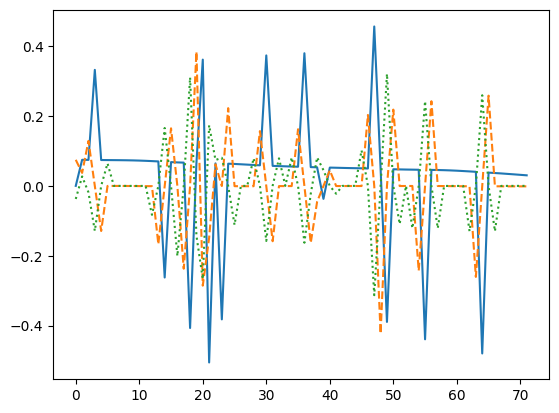

In [127]:
import pandas as pd
series = pd.Series(steering_history)
smoothed_data = series.rolling(window=1, min_periods=1).mean()
first_derivative = np.gradient(steering_history)
second_derivative = np.gradient(first_derivative)
plt.plot(smoothed_data,'-')
plt.plot(first_derivative,'--')
plt.plot(second_derivative,':')

In [2]:
# Define dynamics
def _ode_func(t, z):
    _x, _y, _phi, _delta, _v = z
    u_delta = steering_velocity
    u_a = acceleration
    new_z = np.array([
        -_v * np.sin(_phi),  # swap x-y axis with sign change
        _v * np.cos(_phi),
        _v / self._wheel_base * np.tan(_delta),
        u_delta,
        u_a
    ])
    return new_z

In [ ]:
# Solve ODE
z_0 = np.array(
    [self._x, self._y, self._yaw, self._steering, self._speed])
solver = ode_solve.RK45(_ode_func, 0., z_0, dt)
steps = 0